In [122]:
import numpy as np
import scipy as sp

from scipy.spatial.distance import euclidean

from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import rbf_kernel
from scipy.linalg import cholesky
from sklearn.metrics.pairwise import check_pairwise_arrays
from sklearn.svm import SVC

from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

# Data Generation

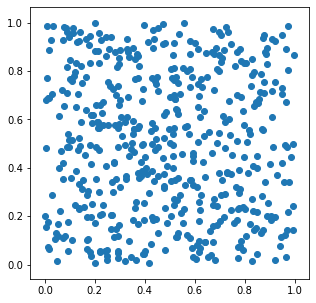

In [2]:
square_dist = np.random.rand(500,2)
plt.scatter(square_dist[:,0], square_dist[:,1])

plt.gcf().set_size_inches(5, 5)

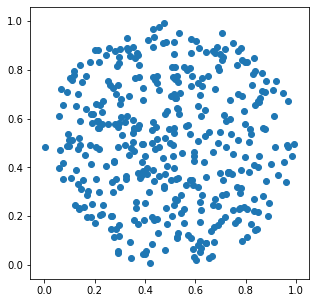

In [3]:
center = np.array([0.5, 0.5])

circle_dist = square_dist[[euclidean(center, d) < 0.5 for d in square_dist]]

plt.scatter(circle_dist[:,0], circle_dist[:,1])

plt.gcf().set_size_inches(5, 5)

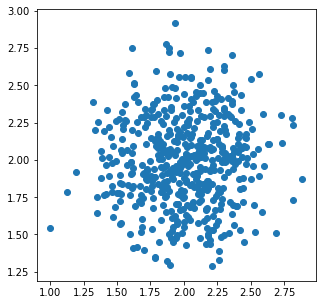

In [4]:
normal_dist = np.random.multivariate_normal([2,2], [[0.1,0],[0,0.1]], size=500)

plt.scatter(normal_dist[:,0], normal_dist[:,1])

plt.gcf().set_size_inches(5, 5)

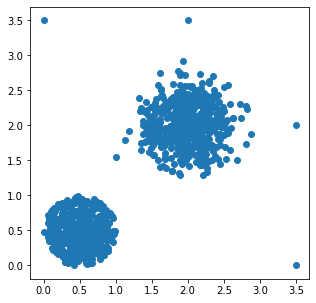

In [5]:
outliers = [[3.5,0], [0, 3.5], [3.5,2], [2,3.5]]
data = np.concatenate([circle_dist, normal_dist, outliers])

plt.scatter(data[:,0], data[:,1])

plt.gcf().set_size_inches(5, 5)

# IREOS

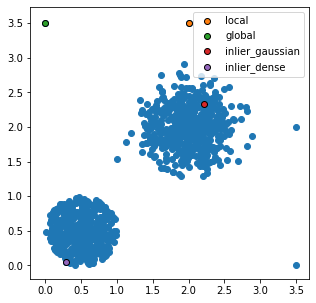

In [114]:
outliers_ix = {
    'local': len(data) - 1,
    'global': len(data) - 3,
    'inlier_gaussian': len(data) - 50,
    'inlier_dense': 5
}

plt.scatter(data[:,0], data[:,1])

for l, i in outliers_ix.items():
    plt.scatter(data[i,0], data[i,1], edgecolors='black', label=l)

plt.legend()
plt.gcf().set_size_inches(5, 5)

# Using KLR

In [262]:
%%timeit
# gammas = np.logspace(np.log10(0.01), np.log10(10), 100)
gammas = np.linspace(0.1, 10, 100)
inlier_class_ = 1
outlier_class_ = -1

evaluations = np.empty([0,len(outliers_ix)])
for gamma in gammas:
    nys = Nystroem(kernel='rbf', gamma=gamma, n_components=len(data))
    K_ = nys.fit_transform(data)
    
    evaluation = np.array([])
    for i_outlier in outliers_ix.values():
        y_outlier = np.ones(data.shape[0])
        y_outlier[i_outlier] = outlier_class_
        lr = LogisticRegression()
        lr.fit(K_, y_outlier)

        # Get probability of the observation being classified as an outlier
        outlier_label_i = np.argwhere(lr.classes_ == outlier_class_)[0,0]
        p = lr.predict_proba([K_[i_outlier]])[0, outlier_label_i]
        evaluation = np.append(evaluation, p)
    
    evaluations = np.concatenate([evaluations, [evaluation]])

21.3 s ± 185 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


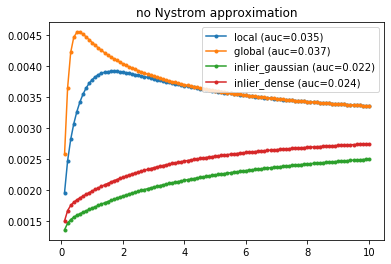

In [263]:
from sklearn.metrics import auc

# outliers_evaluations = np.array([*evaluations.values()]).T
for ev, l in zip(evaluations.T, outliers_ix.keys()):
    ev_auc = auc(gammas, ev)
    plt.plot(gammas, ev, marker='.', label='{} (auc={:.2})'.format(l, ev_auc))

plt.legend()
plt.title('no Nystrom approximation')
plt.show()

In [281]:
%%timeit
# gammas = np.logspace(np.log10(0.01), np.log10(10), 100)
gammas = np.linspace(0.1, 10, 100)
inlier_class_ = 1
outlier_class_ = -1

evaluations = np.empty([0,len(outliers_ix)])
for gamma in gammas:    
    nys = Nystroem(kernel='rbf', gamma=gamma, n_components=int(3*len(data)/4))
    K_ = nys.fit_transform(data)
    
    evaluation = np.array([])
    for i_outlier in outliers_ix.values():
        y_outlier = np.ones(data.shape[0])
        y_outlier[i_outlier] = outlier_class_
        lr = LogisticRegression()
        lr.fit(K_, y_outlier)

        # Get probability of the observation being classified as an outlier
        outlier_label_i = np.argwhere(lr.classes_ == outlier_class_)[0,0]
        p = lr.predict_proba([K_[i_outlier]])[0, outlier_label_i]
        evaluation = np.append(evaluation, p)
    
    evaluations = np.concatenate([evaluations, [evaluation]])

14.6 s ± 305 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


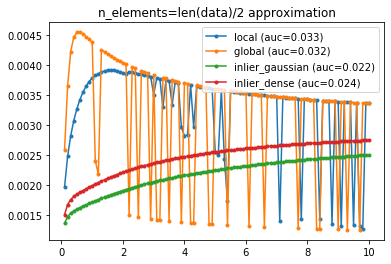

In [280]:
from sklearn.metrics import auc

# outliers_evaluations = np.array([*evaluations.values()]).T
for ev, l in zip(evaluations.T, outliers_ix.keys()):
    ev_auc = auc(gammas, ev)
    plt.plot(gammas, ev, marker='.', label='{} (auc={:.2})'.format(l, ev_auc))

plt.legend()
plt.title('n_elements=len(data)/2 approximation')
plt.show()

# Using SVC

In [274]:
%%timeit
# gammas = np.logspace(np.log10(0.01), np.log10(10), 100)
gammas = np.linspace(0.1, 10, 100)
inlier_class_ = 1
outlier_class_ = -1

evaluations = np.array([])
for i_outlier in outliers_ix.values():
    evaluation = dict()
    y_outlier = np.ones(data.shape[0])
    y_outlier[i_outlier] = outlier_class_

    for gamma in gammas:
        # Create a new model and train
        clf = SVC(gamma=gamma, probability=True)
        clf.fit(data, y_outlier)

        # Get probability of the observation being classified as an outlier
        outlier_label_i = np.argwhere(clf.classes_ == outlier_class_)[0,0]
        p = clf.predict_proba([data[i_outlier]])[0, outlier_label_i]
        evaluation[gamma] = p

    evaluations = np.append(evaluations, evaluation)

1.94 s ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


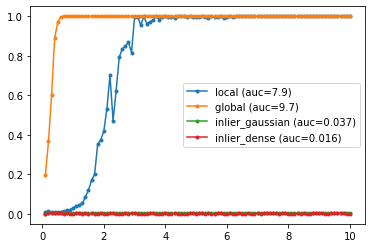

In [275]:
from sklearn.metrics import auc

for ev, l in zip(evaluations, outliers_ix.keys()):
    ev_auc = auc(list(ev.keys()), list(ev.values()))
    plt.plot(list(ev.keys()), list(ev.values()), marker='.', label='{} (auc={:.2})'.format(l, ev_auc))

plt.legend()
plt.show()

# Using SVC+precomputed kernel

In [288]:
%%timeit
# gammas = np.logspace(np.log10(0.01), np.log10(10), 100)
gammas = np.linspace(0.1, 10, 100)
inlier_class_ = 1
outlier_class_ = -1

evaluations = np.empty([0,len(outliers_ix)])
for gamma in gammas:
    K = rbf_kernel(data, gamma=gamma)
    
    evaluation = np.array([])
    for i_outlier in outliers_ix.values():
        y_outlier = np.ones(data.shape[0])
        y_outlier[i_outlier] = outlier_class_
        
        # Create a new model and train
        clf = SVC(kernel='precomputed', gamma=gamma, probability=True)
        clf.fit(K, y_outlier)

        # Get probability of the observation being classified as an outlier
        outlier_label_i = np.argwhere(clf.classes_ == outlier_class_)[0,0]
        p = clf.predict_proba([K[i_outlier]])[0, outlier_label_i]
        evaluation = np.append(evaluation, p)

    evaluations = np.concatenate([evaluations, [evaluation]])

4.1 s ± 250 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


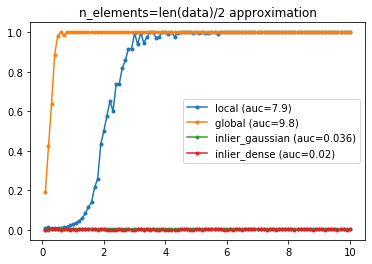

In [287]:
from sklearn.metrics import auc

# outliers_evaluations = np.array([*evaluations.values()]).T
for ev, l in zip(evaluations.T, outliers_ix.keys()):
    ev_auc = auc(gammas, ev)
    plt.plot(gammas, ev, marker='.', label='{} (auc={:.2})'.format(l, ev_auc))

plt.legend()
plt.title('n_elements=len(data)/2 approximation')
plt.show()